In [1]:
import ROOT as R
R.gSystem.Load("libMiniDst")
import numpy as np
import pandas as pd
import sklearn
from sklearn import tree
from sklearn import metrics
from sklearn.ensemble import HistGradientBoostingClassifier
import plotly.express as px
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.28/02


In [2]:
ch = R.TChain("MiniDST")
#ch.Add("/home/lwolf/Analysis/MC2021/events_4p55GeV_000*")
ch.Add("/home/lwolf/Analysis/MC2021/events_4p55GeV*")

print(f"Loaded {ch.GetEntries():,d} events ({ch.GetEntries():7.2e})")
df = R.RDataFrame(ch)

mdst = R.MiniDst()          # Initiate the class
mdst.use_mc_particles=True  # Tell it to look for the MC Particles in the TTree
mdst.use_ecal_cluster_uncor = True
mdst.use_mc_scoring =True
mdst.DefineBranchMap()      # Define the map of all the branches to the contents of the TTree
mdst.SetBranchAddressesOnTree(ch) # Connect the TChain (which contains the TTree) to the class.
print(f"MiniDST version = {mdst._version_()}")

Loaded 92,670 events (9.27e+04)
MiniDST version = 1.1.0


In [4]:
print("Available data names in Tuple:")
ColumnNames=df.GetColumnNames()
ll = 0
pr_colnames = [x for x in ColumnNames if str(x).startswith('ecal')]
for nn in pr_colnames:
    if ll < len(nn):
        ll = len(nn)
for n in range(len(pr_colnames)):
    if n%4 == 0:
        print("")
    print(f"{str(pr_colnames[n]):{ll}s}",end="")

Available data names in Tuple:

ecal_cluster_energy           ecal_cluster_hits             ecal_cluster_mc_id            ecal_cluster_mc_pdg           
ecal_cluster_mc_pdg_purity    ecal_cluster_nhits            ecal_cluster_seed_energy      ecal_cluster_seed_index       
ecal_cluster_seed_ix          ecal_cluster_seed_iy          ecal_cluster_time             ecal_cluster_uncor_energy     
ecal_cluster_uncor_hits       ecal_cluster_uncor_nhits      ecal_cluster_uncor_seed_energyecal_cluster_uncor_seed_index 
ecal_cluster_uncor_seed_ix    ecal_cluster_uncor_seed_iy    ecal_cluster_uncor_time       ecal_cluster_uncor_x          
ecal_cluster_uncor_y          ecal_cluster_uncor_z          ecal_cluster_x                ecal_cluster_y                
ecal_cluster_z                ecal_hit_energy               ecal_hit_index_x              ecal_hit_index_y              
ecal_hit_mc_contrib_ec        ecal_hit_mc_contrib_id        ecal_hit_mc_contrib_pdg       ecal_hit_mc_parent_id         


In [5]:
%%time
#this is the snippet of code that creates the data to be fed into a pandas dataframe
data_dict = {i:[] for i in pr_colnames}  
event_dict = {} 
event_dict['event_id'] = [] 
for event in list(range(0,ch.GetEntries())): 
    ch.GetEntry(event) 
    n_clusters = 0 
    if event % 10000 == 0:
        print(f"Processing event {event:6d}/{ch.GetEntries()}")
    while len(mdst.ecal_cluster_energy) > n_clusters: 
        n_clusters+=1 
        event_dict['event_id'].append(int(event))
        for data_name in pr_colnames:
            x = getattr(mdst,str(data_name))
            data_dict[data_name].append(x[n_clusters-1])
            

Processing event      0/92670
Processing event  10000/92670
Processing event  20000/92670
Processing event  30000/92670
Processing event  40000/92670
Processing event  50000/92670
Processing event  60000/92670
Processing event  70000/92670
Processing event  80000/92670
Processing event  90000/92670
CPU times: user 24.5 s, sys: 3.83 s, total: 28.3 s
Wall time: 28.2 s


In [6]:
#now create a pandas df with the data dictionary
event_dict.update(data_dict)
event_dict.keys() #finally looking okay 
dict_for_df = {'event_id':event_dict['event_id'],'energy':event_dict['ecal_cluster_uncor_energy'],'x':event_dict['ecal_cluster_uncor_x'],
               'y':event_dict['ecal_cluster_uncor_y'],'nhits':event_dict['ecal_cluster_uncor_nhits'],'seed_e':event_dict['ecal_cluster_seed_energy'],
              'seed_ix':event_dict['ecal_cluster_seed_ix'],'seed_iy':event_dict['ecal_cluster_seed_iy'],'true_pdg':event_dict['ecal_cluster_mc_pdg'],
              'true_pdg_purity':event_dict['ecal_cluster_mc_pdg_purity']}
pandas_df = pd.DataFrame(dict_for_df)
pandas_training_df = pandas_df.iloc[0:100000]
pandas_validation_df = pandas_df.iloc[100000:]
print(f"Number of rows in df: {len(pandas_df)}")

Number of rows in df: 154355


In [20]:
muons=pandas_df.loc[np.abs(pandas_df['true_pdg'])>12].loc[pandas_df['nhits']==1]
muons.head()
#muons.shape[0]

,event_id,energy,x,y,nhits,seed_e,seed_ix,seed_iy,true_pdg,true_pdg_purity
2,1,0.172618,296.936066,43.050941,1,0.172618,19,2,13,1.0
3,2,0.183210,171.653870,56.657227,1,0.183210,10,3,13,1.0
6,4,0.151605,-141.406128,-28.417202,1,0.151605,-14,-1,-13,1.0
11,7,0.182258,212.916061,-42.097954,1,0.182258,13,-2,13,1.0
12,7,0.173926,-58.985336,42.969273,1,0.173926,-8,2,-13,1.0


In [22]:
# create a dataframe containing only mup mum pairs and electrons
event_id = []
x = []
y=[]
nhits= []
true_pdg = []
energy = []
seed_e = []
npairs = 0

for i in list(range(0,muons.shape[0]-1)):
    
    first_x = muons['x'].iloc[i]
    second_x = muons['x'].iloc[i+1]
    first_y = muons['y'].iloc[i]
    second_y = muons['y'].iloc[i+1]
    first_pdg = muons['true_pdg'].iloc[i]
    second_pdg = muons['true_pdg'].iloc[i+1] 
      
    if float(first_x*second_x) and float(first_y*second_y) and float(first_pdg*second_pdg) < 0: #this is what selects the pairs
        npairs+=1
        event_id.append(muons['event_id'].iloc[i])
        event_id.append(muons['event_id'].iloc[i+1])
        x.append(muons['x'].iloc[i])
        x.append(muons['x'].iloc[i+1])
        y.append(muons['y'].iloc[i])
        y.append(muons['y'].iloc[i+1])
        true_pdg.append(muons['true_pdg'].iloc[i])
        true_pdg.append(muons['true_pdg'].iloc[i+1])
        energy.append(muons['energy'].iloc[i])
        energy.append(muons['energy'].iloc[i+1])
        seed_e.append(muons['seed_e'].iloc[i])
        seed_e.append(muons['seed_e'].iloc[i+1])

        
print(f"{npairs} muon pairs found")        
data = {'event_id':event_id,'x':x,'y':y,'energy':energy,'seed_e':seed_e,'true_pdg':true_pdg}
muons_pairs = pd.DataFrame(data) 
print(f"stored muon pair events into individual rows in muons_pairs dataframe")

42299 muon pairs found
stored muon pair events into individual rows in muons_pairs dataframe


In [23]:
muons_pairs[0:100]

,event_id,x,y,energy,seed_e,true_pdg
0,2,171.653870,56.657227,0.183210,0.183210,13
1,4,-141.406128,-28.417202,0.151605,0.151605,-13
2,4,-141.406128,-28.417202,0.151605,0.151605,-13
3,7,212.916061,-42.097954,0.182258,0.182258,13
4,7,212.916061,-42.097954,0.182258,0.182258,13
...,...,...,...,...,...,...
95,109,268.667053,56.743904,0.157891,0.157891,13
96,109,268.667053,56.743904,0.157891,0.157891,13
97,110,171.653870,29.308418,0.173758,0.173758,-13
98,110,171.653870,29.308418,0.173758,0.173758,-13


In [24]:
electrons = pandas_df.loc[np.abs(pandas_df['true_pdg'])==11]
electrons_shortened = electrons[['event_id','x','y','energy','seed_e','true_pdg']]
electrons.head()

,event_id,energy,x,y,nhits,seed_e,seed_ix,seed_iy,true_pdg,true_pdg_purity
0,0,0.125395,-31.799932,-83.099800,1,0.125395,-6,-5,11,1.000000
5,3,0.175812,-190.847427,70.480156,2,0.102449,-18,4,11,0.582720
8,5,1.024133,-188.391846,-28.426920,4,0.727388,-17,-1,11,0.786460
9,5,0.169475,-188.842194,56.750229,2,0.123345,-17,3,11,0.727808
10,6,0.193870,157.982498,-42.073868,1,0.193870,9,-2,11,1.000000


In [25]:
high_purity_df = pd.concat([muons_pairs,electrons_shortened],ignore_index = True)
pure_shuffle= high_purity_df.sample(frac = 1)
pure_shuffle.shape[0]


131035

In [26]:
pure_training = pure_shuffle[0:120000]
pure_testing = pure_shuffle[120000:]

In [27]:
pure_training.head()

,event_id,x,y,energy,seed_e,true_pdg
85069,973,-58.211525,-44.827610,2.307671,1.762133,11
103362,37285,-170.067230,50.630379,2.393414,1.104774,11
46728,51289,212.916061,70.390892,0.215085,0.215085,13
87429,5660,-90.596199,-42.080837,1.909135,1.368987,11
41121,44952,144.345764,-28.405161,0.185372,0.185372,-13


In [45]:
X_train = pure_training.drop(columns=['true_pdg','event_id','energy','x','y']) #remove the 'truth' aka pdg_id column from the features dataset
X_test = pure_testing.drop(columns=['true_pdg','event_id','energy','x','y']) #same thing, but for the df for testing the model
Y_train = pure_training['true_pdg'] #this is the df containing the truth values for the X_train features, aka which particle they are
Y_test = pure_testing['true_pdg'] #contains truth values for the test set 
X_train.head(),Y_train.head()

(          seed_e
 85069   1.762133
 103362  1.104774
 46728   0.215085
 87429   1.368987
 41121   0.185372,
 85069     11
 103362    11
 46728     13
 87429     11
 41121    -13
 Name: true_pdg, dtype: int64)

In [52]:
%%time
#train with my df
clf = tree.DecisionTreeClassifier()

clf.set_params(criterion='entropy',max_depth=2,max_leaf_nodes=2)
clf.fit(X_train, Y_train)
clf_pred = clf.predict(X_test)
clf_score = clf.score(X_test, Y_test)
print("MY DF RESULTS:")
print("Training set score: %f" % clf.score(X_train, Y_train))
print("Test set score (how accurate the model is at classifying mu+/e-/mu-/e+): %f" % clf.score(X_test, Y_test))
print(f"So using {X_train.shape[0]} training points and {X_test.shape[0]} testing datapoints, we on average have a {(1-clf.score(X_test,Y_test))*100} % error at classifying 3 different kinds of particles")


MY DF RESULTS:
Training set score: 0.508008
Test set score (how accurate the model is at classifying mu+/e-/mu-/e+): 0.503670
So using 120000 training points and 11035 testing datapoints, we on average have a 49.63298595378342 % error at classifying 3 different kinds of particles
CPU times: user 78 ms, sys: 390 µs, total: 78.4 ms
Wall time: 76.6 ms


[Text(0.5, 0.75, 'x[0] <= 0.308\nentropy = 1.584\nsamples = 120000\nvalue = [38770, 42550, 38680]'),
 Text(0.25, 0.25, 'entropy = 1.529\nsamples = 97276\nvalue = [38588, 20177, 38511]'),
 Text(0.75, 0.25, 'entropy = 0.13\nsamples = 22724\nvalue = [182, 22373, 169]')]

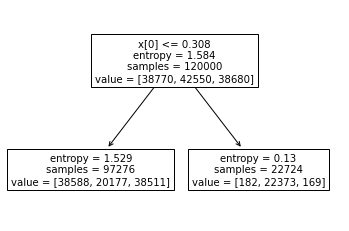

In [53]:
tree.plot_tree(clf)

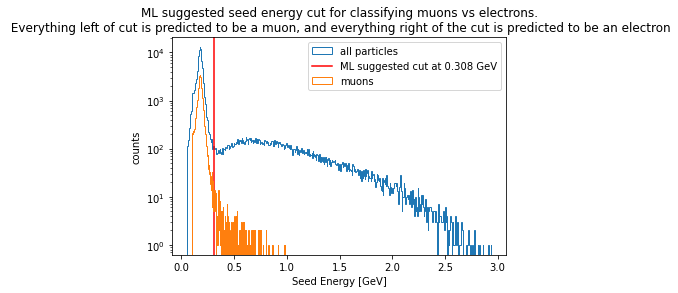

In [55]:
import matplotlib.pyplot as plt
seed_e_hist = plt.hist(high_purity_df['seed_e'],bins=500,label='all particles',histtype='step')
plt.axvline(x = 0.308, color = 'red', label = 'ML suggested cut at 0.308 GeV')
muons = plt.hist(high_purity_df['seed_e'].loc[np.abs(high_purity_df['true_pdg'])>12],bins = 500,label='muons',histtype='step')
plt.yscale('log')
plt.xlabel('Seed Energy [GeV]')
plt.ylabel('counts')
plt.title("ML suggested seed energy cut for classifying muons vs electrons.\n Everything left of cut is predicted to be a muon, and everything right of the cut is predicted to be an electron")
plt.legend()

In [59]:
n_muons_incorrect = high_purity_df.loc[high_purity_df['seed_e']>.308].loc[np.abs(high_purity_df['true_pdg'])>12]
n_electrons_correct = high_purity_df.loc[high_purity_df['seed_e']>.308].loc[high_purity_df['true_pdg']==11]
n_muons_correct = high_purity_df.loc[high_purity_df['seed_e']<.308].loc[np.abs(high_purity_df['true_pdg'])>12]
n_electrons_incorrect = high_purity_df.loc[high_purity_df['seed_e']<.308].loc[high_purity_df['true_pdg']==11]
print(f"correct muon prediction count: {n_muons_correct.shape[0]}")
print(f"incorrect muon prediction count: {n_muons_incorrect.shape[0]}")
print(f"correct electron prediction count: {n_electrons_correct.shape[0]}")
print(f"incorrect electron prediction count: {n_electrons_incorrect.shape[0]}")
print(f"total score:{(n_muons_correct.shape[0]+n_electrons_correct.shape[0])/high_purity_df.shape[0]}")
print("If we don't care about whether the muon was positively or negatively charged, this cut does quite well!")

correct muon prediction count: 84208
incorrect muon prediction count: 390
correct electron prediction count: 24429
incorrect electron prediction count: 22008
total score:0.8290685694661731
If we don't care about whether the muon was positively or negatively charged, this cut does quite well!


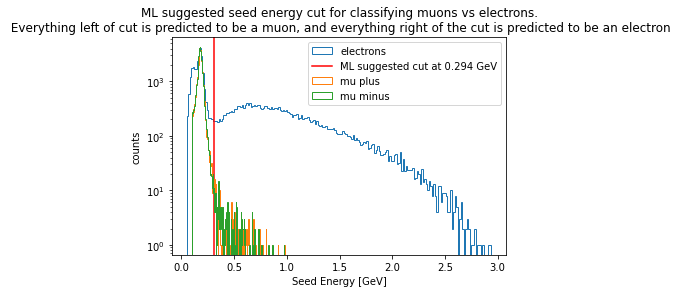

In [57]:
seed_e_hist = plt.hist(high_purity_df['seed_e'].loc[high_purity_df['true_pdg']==11],bins=200,label='electrons',histtype='step')
plt.axvline(x = 0.308, color = 'red', label = 'ML suggested cut at 0.294 GeV')
mups = plt.hist(high_purity_df['seed_e'].loc[high_purity_df['true_pdg']==-13],bins = 200,label='mu plus',histtype='step')
mums = plt.hist(high_purity_df['seed_e'].loc[high_purity_df['true_pdg']==13],bins = 200,label='mu minus',histtype='step')
plt.yscale('log')
plt.xlabel('Seed Energy [GeV]')
plt.ylabel('counts')
plt.title("ML suggested seed energy cut for classifying muons vs electrons.\n Everything left of cut is predicted to be a muon, and everything right of the cut is predicted to be an electron")
plt.legend()